In [127]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import numpy as np
import joblib
import sys
import imodelsx.process_results
sys.path.append('../experiments/')
results_dir = '../results/'

r = imodelsx.process_results.get_results_df(results_dir)
experiment_filename = '../experiments/01_train_model.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
# r.to_pickle('../results/agg.pkl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 2251/2251 [00:00<00:00, 4310.62it/s]


In [128]:
def calc_mean_std_across_curves(shape_function_vals_list_list):
    '''
    shape_function_vals_list_list: list of lists of arrays
        num_seeds x num_features x num_points
    '''
    stds = []
    n_features = len(shape_function_vals_list_list[0])
    for feature_num in range(n_features):
        shape_function_vals = np.array(
            [
                shape_function_vals_list_list[i][feature_num]
                for i in range(len(shape_function_vals_list_list))
            ]
        )
        shape_function_mean = np.mean(shape_function_vals, axis=0)
        stds.append(np.mean(np.std(shape_function_vals, axis=0)))
    return 100 * np.mean(stds)

In [129]:
ravg = []
group_keys = [k for k in imodelsx.process_results.get_main_args_list(experiment_filename='01_train_model.py') if not k == 'seed']
rg = r.groupby(group_keys)
for group_key, group_idx in rg.groups.items():
    g = r.iloc[group_idx]
    numeric_keys = [k for k in list(g.select_dtypes("number")) if not k in group_keys]
    # numeric_keys = ['roc_auc_test', 'stability']
    row = g[numeric_keys].mean()
    for k in group_keys:
        row[k] = g[k].iloc[0]
    row['stability'] = calc_mean_std_across_curves(g['shape_function_vals_list'].values.tolist())
    ravg.append(row)

In [130]:
df = pd.DataFrame(ravg)
k = 'reg_param_marginal'
for val in df[k].unique():
    print(f'k={k}, val={val}')
# for fit_linear_marginal in df['fit_linear_marginal'].unique():
    # print('fit_linear_marginal =', fit_linear_marginal)
    df = pd.DataFrame(ravg)
    df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
    df = df[df[k] == val]
    print('ROC AUC:')
    display(
        df.pivot_table(
            index="n_boosting_rounds",
            columns="n_boosting_rounds_marginal",
            values="roc_auc_test",
            aggfunc="mean",
        )
        .style.format(precision=3)
        .background_gradient(cmap="RdBu", axis=None)
    )
    print('Stability:')
    display(
        (df.pivot_table(
            index="n_boosting_rounds",
            columns="n_boosting_rounds_marginal",
            values="stability",
            aggfunc="mean",
        ))
        .style.format(precision=4)
        .background_gradient(cmap="RdBu_r", axis=None)
    )

k=reg_param_marginal, val=0.0
ROC AUC:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.840,0.850,0.848
5,0.852,0.850,0.857,0.857
25,0.865,0.865,0.868,0.862
125,0.858,0.859,0.862,0.861


Stability:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.0305,0.0989,0.1873
5,0.0893,0.1079,0.1611,0.2329
25,0.2227,0.2008,0.2445,0.3660
125,0.5919,0.5459,0.5639,0.6216


k=reg_param_marginal, val=100.0
ROC AUC:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.834,0.850,0.850
5,0.850,0.850,0.855,0.857
25,0.865,0.865,0.867,0.862
125,0.858,0.858,0.861,0.861


Stability:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.0251,0.0754,0.1388
5,0.0945,0.1030,0.1523,0.2018
25,0.2227,0.2091,0.2484,0.3409
125,0.5919,0.5625,0.5638,0.6105


k=reg_param_marginal, val=10000.0
ROC AUC:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.840,0.850,0.850
5,0.852,0.852,0.854,0.854
25,0.865,0.865,0.865,0.860
125,0.858,0.859,0.859,0.860


Stability:


n_boosting_rounds_marginal,0,5,25,125
n_boosting_rounds,,,,
0,nan,0.0010,0.0037,0.0072
5,0.0893,0.0887,0.0909,0.0934
25,0.2227,0.2167,0.2307,0.2641
125,0.5919,0.5405,0.5579,0.5397


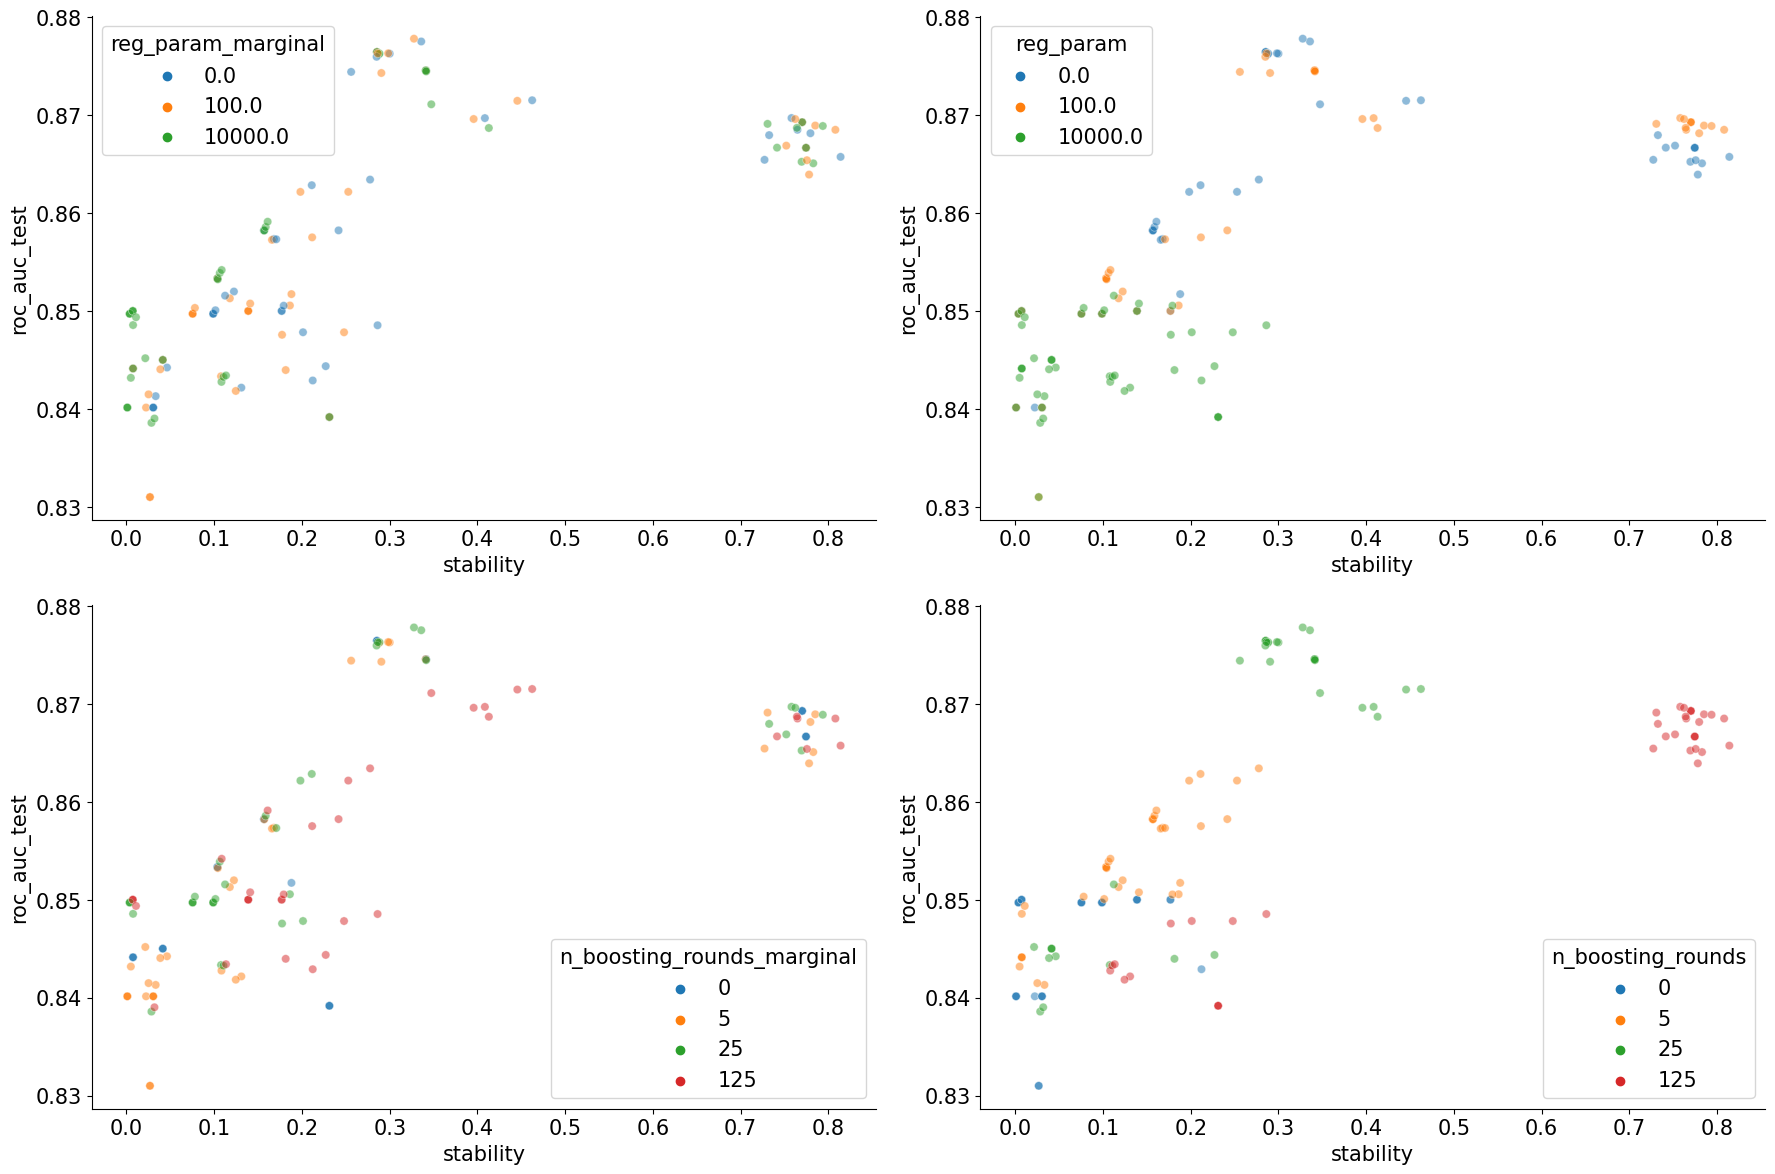

In [131]:
df = pd.DataFrame(ravg)
df = (
    df.groupby([k for k in group_keys if not k == "dataset_name"])[
        ["roc_auc_test", "stability"]
    ]
    .mean()
    .reset_index()
)
df = df[~((df.n_boosting_rounds == 0) & (df.n_boosting_rounds_marginal == 0))]
# df = df[df.fit_linear_marginal == "None"]
# df = df[df.n_boosting_rounds == 0]
# df = df[df.n_boosting_rounds_marginal == 5]
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
kwargs = dict(
    data=df,
    x="stability",
    y="roc_auc_test",
    palette="tab10",
    alpha=0.5,
)
sns.scatterplot(
    **kwargs,
    hue="reg_param_marginal",
    ax=axes[0, 0],
)
sns.scatterplot(
    **kwargs,
    hue="reg_param",
    # hue="n_boosting_rounds_marginal",
    # hue="n_boosting_rounds",
    ax=axes[0, 1],
)
sns.scatterplot(
    **kwargs,
    hue="n_boosting_rounds_marginal",
    ax=axes[1, 0],
)
sns.scatterplot(
    **kwargs,
    hue="n_boosting_rounds",
    ax=axes[1, 1],
)
plt.show()

Load an individual model

In [98]:
run_args = r.iloc[0]
model = joblib.load(join(run_args.save_dir_unique, 'model.pkl'))
model

TreeGAMClassifier(n_boosting_rounds=5, random_state=1)